In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-06-04 12:14:13--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

num_color_bins = 50 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 2e-8, 5e-8, 1e-7]
regularization_strengths = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6, 2e6, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hyperparams = [(lr, rg) for lr in learning_rates for rg in regularization_strengths]
for lr, rg in hyperparams:
    svm = LinearSVM()
    tr_loss = svm.train(X_train_feats, y_train, learning_rate = lr, reg = rg,
                        num_iters=1500, verbose=True)
    y_tr_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    tr_acc = np.mean(y_tr_pred == y_train)
    val_acc = np.mean(y_val_pred == y_val)
    if(val_acc > best_val):
      best_val = val_acc
      best_svm = svm
    results[(lr, rg)] = (tr_acc, val_acc)

    

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 28.952913
iteration 100 / 1500: loss 28.872034
iteration 200 / 1500: loss 28.799713
iteration 300 / 1500: loss 28.709474
iteration 400 / 1500: loss 28.625443
iteration 500 / 1500: loss 28.545147
iteration 600 / 1500: loss 28.473453
iteration 700 / 1500: loss 28.379640
iteration 800 / 1500: loss 28.312735
iteration 900 / 1500: loss 28.241355
iteration 1000 / 1500: loss 28.169045
iteration 1100 / 1500: loss 28.096287
iteration 1200 / 1500: loss 28.013311
iteration 1300 / 1500: loss 27.937063
iteration 1400 / 1500: loss 27.848801
iteration 0 / 1500: loss 49.005539
iteration 100 / 1500: loss 48.720163
iteration 200 / 1500: loss 48.376150
iteration 300 / 1500: loss 48.067945
iteration 400 / 1500: loss 47.759186
iteration 500 / 1500: loss 47.446081
iteration 600 / 1500: loss 47.136644
iteration 700 / 1500: loss 46.830051
iteration 800 / 1500: loss 46.542446
iteration 900 / 1500: loss 46.253525
iteration 1000 / 1500: loss 45.951009
iteration 1100 / 1500: loss 45.64983

In [ ]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


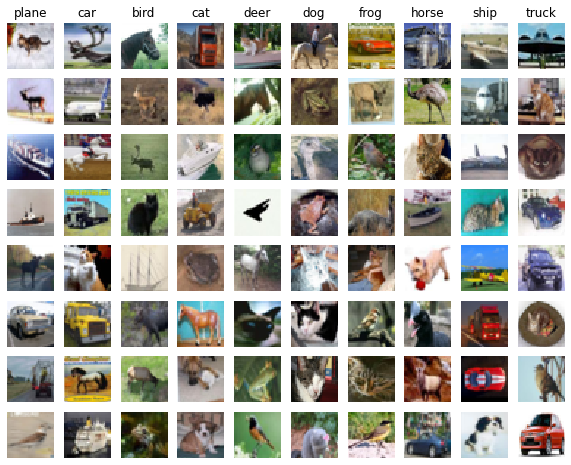

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
For some classes they make sense. For instance, cats and dogs are animals that have similar appearance in the sense of edges, they both have four legs and one tail. Thus, images from these classes can be mixed up, we can also include here horses or deers. A similar example is the case of cars and trucks. The plane class is interesting because the misclassified examples have similarities in the sense of colors, thus they are commonly mixed up with ship images because the sky and sea colors are very similar. However, there are classes that do not make sense at all, it is the case of the bird class where images of dogs, cats, planes and others are misclassified. We can assume all these images where classified as bird because of the color features.

In conclusion, the combination of HOG and color histogram feature vectors are not enough to discriminate correctly all the classes. The HOG descriptor is very useful because it takes into account the edges, but we have to take into account different type of invariances that HOG might not consider, e.g., invariance to translation. Besides that, HOG has different parameters that we can cross-validate for a better performance. Color histogram features can help in some cases (similar colors) but are not very helpful for others. However, we can still consider this features but maybe with a lower importance when combining it with other features like HOG. Finally, we can use other type of descriptors to improve the accuracy of our model, e.g., SIFT, LBP (texture), etc.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 195)
(49000, 194)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
best_val = -1.0

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden
    

for i in range(20):
    lr, rg, hidden_dim = generate_random_hyperparams(-1, 0, -7, -4, 10, 500)
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=3000, batch_size = 200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg = rg, verbose = False)
    tr_acc = np.mean(net.predict(X_train_feats) == y_train)
    val_acc = np.mean(net.predict(X_val_feats) == y_val)
    if val_acc > best_val:
      best_val = val_acc
      best_net = net
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, rg, hidden_dim, tr_acc, val_acc))

print('best validation accuracy achieved: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr 1.263139e-01 reg 2.445408e-06 hid 299  train accuracy: 0.625633 val accuracy: 0.593000
lr 3.653329e-01 reg 3.890050e-06 hid 424  train accuracy: 0.762571 val accuracy: 0.590000
lr 1.707361e-01 reg 4.657106e-06 hid 368  train accuracy: 0.666102 val accuracy: 0.613000
lr 1.778747e-01 reg 1.140415e-05 hid 479  train accuracy: 0.678592 val accuracy: 0.599000
lr 5.285869e-01 reg 6.158310e-07 hid 468  train accuracy: 0.815959 val accuracy: 0.595000
lr 4.367850e-01 reg 8.271054e-06 hid 312  train accuracy: 0.772286 val accuracy: 0.588000
lr 4.004196e-01 reg 4.038519e-07 hid 383  train accuracy: 0.771327 val accuracy: 0.579000
lr 8.826526e-01 reg 5.896168e-07 hid 298  train accuracy: 0.820143 val accuracy: 0.574000
lr 2.088159e-01 reg 3.822217e-07 hid 186  train accuracy: 0.671633 val accuracy: 0.587000
lr 4.537346e-01 reg 6.822322e-07 hid 160  train accuracy: 0.724224 val accuracy: 0.578000
lr 2.284905e-01 reg 3.295055e-05 hid 49  train accuracy: 0.617082 val accuracy: 0.574000
lr 4.327405

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.594


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))